# Movie Lense Recommender system <a class='tocskip'>

## Sang-Yun Oh <a class='tocskip'>

We will build a basic recommender system using [Movie Lense 100K dataset](https://grouplens.org/datasets/movielens/).

## Downloading data

In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip -O movie-lense.zip\
    && unzip -o movie-lense.zip

--2019-10-28 17:40:36--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘movie-lense.zip’

movie-lense.zip     100%[===================>]   4.70M  2.99MB/s    in 1.6s    

2019-10-28 17:40:38 (2.99 MB/s) - ‘movie-lense.zip’ saved [4924029/4924029]

Archive:  movie-lense.zip
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         


## Importing Data

### Movie Lense Metadata

`README` file contains metadata. Relevant lines are:

* `u.data`: The full u data set, 100000 ratings by 943 users on 1682 items 
    ```
    user id | item id | rating | timestamp
    ```

* `u.item`: Information about the items (movies).
    ```
    movie id | movie title | release date | video release date |
    IMDb URL | unknown | Action | Adventure | Animation |
    Children's | Comedy | Crime | Documentary | Drama | Fantasy |
    Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
    Thriller | War | Western |
    ```

* `u.genre`: A list of the genres.

* `u.user`: Demographic information about the users;
    ```
    user id | age | gender | occupation | zip code
    ```

* `u.occupation`: A list of the occupations.

In [2]:
!head -n3 ml-100k/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116


In [3]:
!head -n3 ml-100k/u.user

1|24|M|technician|85711
2|53|F|other|94043
3|23|M|writer|32067


In [4]:
!head -n3 ml-100k/u.item

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0


In [5]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

### Importing to Pandas DataFrame

In [6]:
ratings_list = [l.split('\t') for l in Path('ml-100k/u.data').read_text().split('\n')]
users_list   = [l.split('|')  for l in Path('ml-100k/u.user').read_text().split('\n')]
movies_list  = [l.split('|')  for l in Path('ml-100k/u.item').read_text(encoding = "ISO-8859-1").split('\n')]

Each file is read into a list, where each item is another list of items for one row.

Converting each list to a data frame, clean up, and set correct data types.

In [7]:
ratings = pd.DataFrame(
    ratings_list,
    columns='user id | item id | rating | timestamp'.split(' | '),
).dropna().astype(
    {'user id':'str', 'item id':'str', 'rating':'int', 'timestamp':'int'}
)

users = pd.DataFrame(
    users_list,
    columns='user id | age | gender | occupation | zip code'.split(' | '),
).dropna().astype(
    {'user id':'str', 'age':'str', 'gender':'str', 'occupation':'str', 'zip code':'str'}
).set_index('user id')

movies = pd.DataFrame(
    movies_list,
    columns='movie id | movie title | release date | video release date | '\
        'IMDb URL | unknown | Action | Adventure | Animation | '\
        'Children\'s | Comedy | Crime | Documentary | Drama | Fantasy | '\
        'Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | '\
        'Thriller | War | Western'.split(' | '),
).dropna()

d = {'movie id':'str', 'movie title':'str', 'release date':'str', 'video release date':'str', 'IMDb URL':'str'}
d.update([(g, bool) for g in movies.columns.values[-19:]]) 

movies = movies.astype(d).set_index('movie id')

## Transforming Data

### Create Ratings: Pivot Table

* Create a matrix of ratings: $R = (r_{im})$ for individuals, $i$, and movies, $m$
* Individuals: $i=1,2,\dots,I$
* Movies: $m=1,2,\dots,M$

In [8]:
R = ratings.pivot(index = 'user id', columns ='item id', values = 'rating').fillna(0)

In [9]:
col_order = R.columns.astype('int').sort_values().astype('str')
row_order = R.index.astype('int').sort_values().astype('str')

R = R.loc[row_order, col_order] # order rows and columns by ids
R.head()

item id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Subset Ratings

Create a manageable dataset: 15 users and 11 movies

In [10]:
I = 15
M = 11
topusers = ratings.groupby('user id').size().sort_values(ascending=False).head(70).tail(I)
topmovies = ratings.groupby('item id').size().sort_values(ascending=False).head(70).tail(M)

Rsub = R.loc[topusers.index, topmovies.index]
Rsub

item id,289,238,97,268,546,196,186,70,333,475,153
user id,,,,,,,,,,,
291,0.0,5.0,4.0,0.0,3.0,0.0,0.0,4.0,0.0,5.0,4.0
864,0.0,5.0,4.0,0.0,4.0,4.0,4.0,4.0,5.0,0.0,5.0
311,0.0,4.0,4.0,0.0,0.0,5.0,3.0,4.0,0.0,0.0,0.0
747,0.0,3.0,5.0,5.0,0.0,2.0,0.0,4.0,4.0,5.0,4.0
85,3.0,2.0,2.0,4.0,0.0,4.0,3.0,4.0,1.0,0.0,3.0
286,5.0,0.0,4.0,4.0,1.0,4.0,5.0,5.0,0.0,4.0,5.0
327,0.0,4.0,0.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,4.0
328,4.0,0.0,3.0,0.0,3.0,0.0,4.0,4.0,3.0,0.0,2.0
653,0.0,1.0,3.0,0.0,2.0,2.0,5.0,2.0,5.0,0.0,2.0


### Visualizing Data and Missing Values

Zeros indicate missing ratings. To visualize the missing values, plot the following heatmap

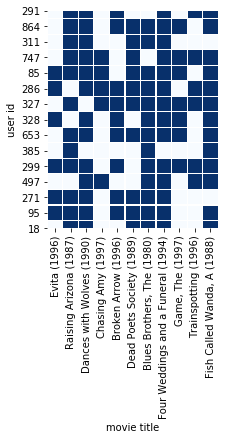

In [11]:
Rsub.set_axis(movies.loc[topmovies.index,'movie title'], axis=1, inplace=True) 
sns.heatmap(Rsub.astype('bool'), cbar=False, cmap='Blues', square=True, linewidths=0.1);

## Optimization

- Find $U$ and $V$ that fit the data well
\begin{align*}
\min_{U,V} \|R - UV^T\|_F^2
\end{align*}

- Break down problem shows how to choose $u_i$ and $v_m$:
\begin{align*}
\min_{U,V} \left\{ \sum_{i=1}^I\sum_{m=1}^M (r_{im} - u_i^T v_m)^2 \right\}
\end{align*}

- Such problems can be solved via optimization:
$$x^* = \arg\min_y f(y)$$

### Why Optimize?

* Finding the set of conditions that give _best_ outcome

* Problem definition must define what _best_ means: loss/score function

* Set of conditions: $x$, outcome: $f(x)$

* Portfolio optimization: allocation ($\mathbf{w}$), expected return ($\mu$), expected volatility ($\mathbf{\Sigma}$)
    $$
\begin{aligned} \min _{\mathbf{w}} &\frac{1}{2} \mathbf{w}^{\prime} \mathbf{\Sigma} \mathbf{w} \\ \text { subject to } & \mathbf{w}^{\prime} \mu=p \\ \text { and } & \mathbf{w}^{\prime} \mathbf{1}=1 \end{aligned}
$$

* Transportation problem: $i$ and $j$ indicate pairs of locations, quantity of goods ($x_{ij}$), supply ($s_i$), demand ($d_j$), transportation network ($\mathcal{A}$)
$$
\begin{aligned}
\min_{x=(x_{ij})\geq0} &\sum_{(i, j) \in \mathcal{A}} c_{i j} x_{i j}\\
\text{sugject to }&\sum_{j:(i, j) \in \mathcal{A}} x_{i j} \leq s_{i} \quad \text { for all } i\\
&\sum_{i:(i, j) \in \mathcal{A}} x_{i j} \geq d_{j} \quad \text { for all } j
\end{aligned} 
$$

* Amount of goods delivered does not exceed supply  

* Amount of goods delivered meets the demand
    

###  Direction of Function Decrease

- Given function $f(x)$, we want to find the minimizing value $x^*$:
$$ x^* = \arg\min_x f(x). $$

- (Harder) From some point, $x=a$, which way (left/right) is minimum?

- (Easier) From some point, $x=a$, which way (left/right) _decreases_ $f(x)$?

- Repeatedly decrease $f(x)$ by adjusting $x$

- When $f(x)$ stops decreasing ($x$ converges to a point), stop

- **How to determine the direction of function decrease?**

### Example: $f(x) = (x+1)^2$ and $x\in\mathbb{R}$

- Differentiable convex function $g(x)$ satisfies
$$g(x) \geq g(a) + g'(a)(x-a),$$
for any valid $x$ and $a$ 

- Quadratic function $f(x)$ is convex and minimum is at $x=-1$

- Value $f(x)$ decreases as $x$ gets closer to $x=-1$.

* We want to find $b$ that gives
$$f(a) - f(b) \geq 0$$

* We can show that $b$ satisfies
$$f'(a)(b-a) \leq 0$$

- Satisfying $f^{\prime}(a)(b-a)\leq 0$
    - Case 1: if slope $f'(a)<0$, we need $b>a$: i.e. move right. 
    - Case 2: if slope is $f'(a)>0$, we need $b<a$: i.e. move left
    - Case 3: if slope is $f'(a)=0$, we are at the minimum
    
- $b \leftarrow a - f'(a)$ is a possibility, but could overshoot!

- How big of a step? For now, small amount $\alpha$ (step size)
    $$b \leftarrow a - \alpha\cdot f'(a)$$

In [12]:
def f(x): return (x+1)**2
def fprime(x): return 2*(x+1)

def find_minimum_1(func, slope, a = 2, step=0.1, max_iter=1000):
    
    for i in range(0, 1000):
        
        # find next target point
        b = a - step*slope(a)
        
        # set target point as the new starting point
        a = b
    
    return b

  xstar  = -1.000000, f(xstar) = 0.000000


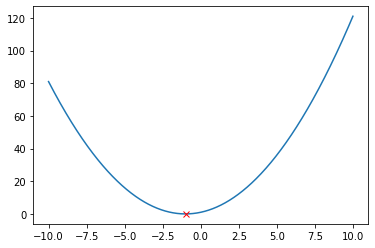

In [13]:
x = np.linspace(-10, 10, num=1000)
xstar = find_minimum_1(f, fprime)

print('  xstar  = %f, f(xstar) = %f' % (xstar, f(xstar)))

sns.lineplot(x, f(x))
plt.plot(xstar, f(xstar), 'xr')
plt.show()

### Exercise: Find the minimum of $g(x)$

$g(x) = (x-3.2)^2 - x + 2.3$ and $x\in\mathbb{R}$

  xstar  = 3.700000, g(xstar) = -1.150000


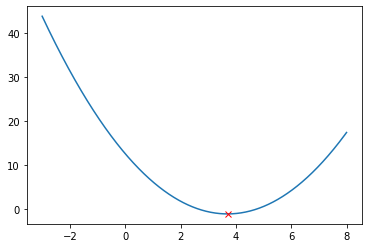

In [14]:
def g(x): return (x-3.2)**2 - x + 2.3
def gprime(x): return 2*(x-3.2) - 1

x = np.linspace(-3, 8, num=1000)
xstar = find_minimum_1(g, gprime)

print('  xstar  = %f, g(xstar) = %f' % (xstar, g(xstar)))

sns.lineplot(x, g(x))
plt.plot(xstar, g(xstar), 'xr')
plt.show()

In [15]:
def find_minimum_2(func, slope, x0 = 2, rate=0.1, message=False):
    
    c = 0
    for i in range(0, 1000):
        
        x = x0 - rate*slope(x0)
        
        if np.isclose(x, x0, rtol=1e-5):
            if message:
                print('converged in %d iterations' % c)
            return x
        
        if func(x) < func(x0):
            x0 = x
            c += 1
        else:
            rate *= rate
    
    print('warning: algorithm did not converge')
    
    return x 

### Complexity vs. Running time

In [16]:
# smarter algorithm
xstar = find_minimum_2(g, gprime, message=True) ## less number of loops
g(xstar)

converged in 41 iterations


-1.1499999790850541

In [17]:
%timeit -n10 -r10 find_minimum_1(g, gprime) ## faster running time
%timeit -n10 -r10 find_minimum_2(g, gprime) ## slower running time

295 µs ± 96.4 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
2.74 ms ± 69.6 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


## Back to Recommender System: Calculating $U$ and $V$

- In recommender system, we want to find $U$ and $V$ that minimize the residual:
\begin{align*}
\min_{U,V} \|R - UV^T\|_F^2 
\end{align*}
- However, due to missing values, we minimize over just the observed ratings: i.e.,
\begin{align*}
\min_{U,V} f(U,V) &= \min_{U,V} \left\{ \sum_{r_{im}\in R} f_{im}(u_i, v_m) \right\}\tag{only observed ratings}\\
&= \min_{U,V} \left\{ \sum_{r_{im}\in R} (r_{im} - u_i^T v_m)^2 \right\}
\end{align*}

- Since $f(U,V)$ is a sum of quadratic (convex) functions, we can cycle through decreasing $f_{ij}(u_i,v_m)$ respect to vectors $u_i$ and $v_m$ eventually decreases the sum.

- In order to apply the update equations as in the toy examples, we compute the gradients:
\begin{align*}
\frac{\partial}{\partial u_i} f_{ij}(u_i,v_m) &= -2(r_{ij} - u_i^T v_m)\cdot v_m\\
\frac{\partial}{\partial v_m} f_{ij}(u_i,v_m) &= -2(r_{ij} - u_i^T v_m)\cdot u_i.
\end{align*}

- Now, the update formulas are
\begin{align*}
u_i^{\text{new}} &= u_i + 2\alpha(r_{ij} - u_i^T v_m)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha(r_{ij} - u_i^T v_m)\cdot u_i,
\end{align*}
where $\alpha$ is the step-size

### Setup Variables

In [18]:
RsubMask = (Rsub!=0).astype('int')  # 0: missing, 1: observed
RsubOnes = (1+0*Rsub).astype('int') # all ones

nonzero_loc = np.where(Rsub!=0)

# number of latent factors
k = 5
U = np.random.uniform(0, 2, size=k*I).reshape((I, k))
V = np.random.uniform(0, 2, size=k*M).reshape((M, k))

### Run Optimization

In [19]:
residual2 = []

rate = 0.1
for t in range(0, 300):
    
    # compute error after one sweep of updates
    E = (Rsub - np.inner(U, V))*RsubMask
    residual2 += [np.linalg.norm(E, 'fro')]
    
    for i, m in zip(*nonzero_loc):
        
        U[i] = U[i] + rate*V[m]*(Rsub.iloc[i,m] - np.inner(U[i], V[m]))
        V[m] = V[m] + rate*U[i]*(Rsub.iloc[i,m] - np.inner(U[i], V[m]))

### Visualize Recommendations

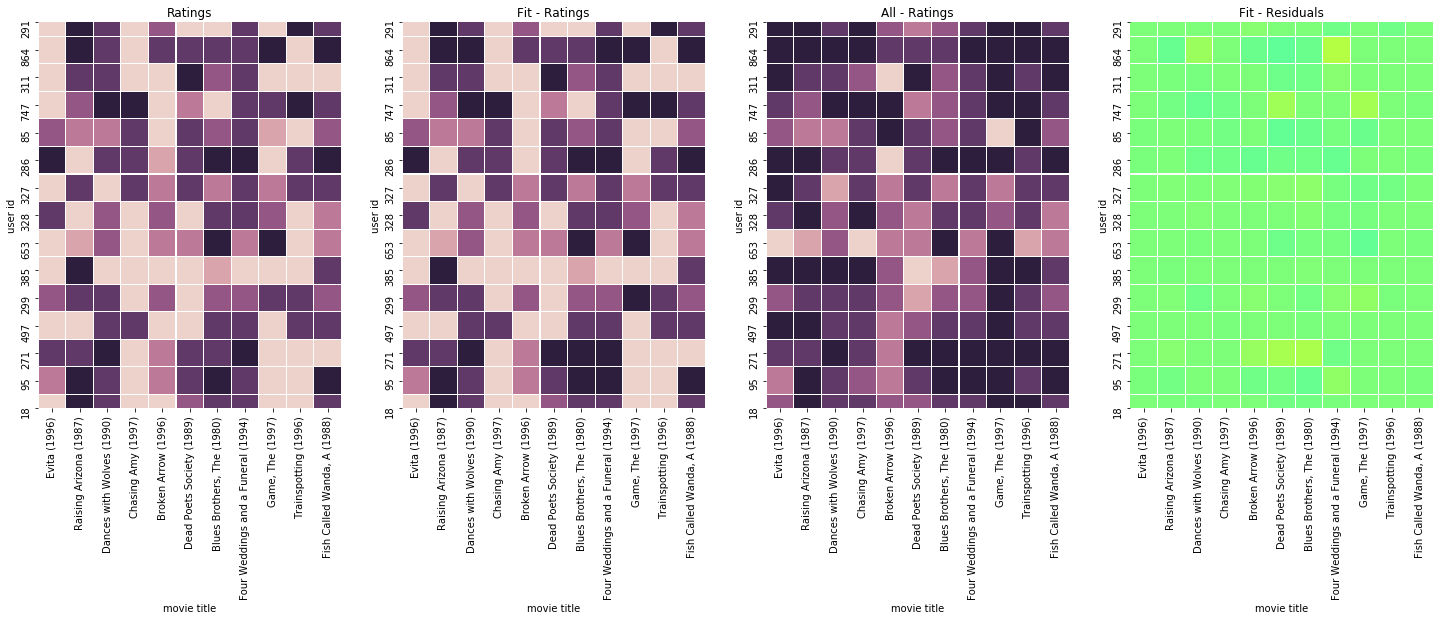

In [20]:
RsubFit = pd.DataFrame(np.inner(U, V)*RsubOnes)

RsubFitFixed = np.minimum(RsubFit, 5)
RsubFitFixed = np.maximum(RsubFitFixed, 0)

fig, ax = plt.subplots(ncols=4, figsize=(25, 15))
sns.heatmap(Rsub,
            ax=ax[0], vmin=0, vmax=5, square=True, linewidths=0.1,
            cbar=False, cmap=sns.cubehelix_palette(6));
ax[0].set_title('Ratings')

sns.heatmap(RsubFitFixed*RsubMask, 
            ax=ax[1], vmin=0, vmax=5, square=True, linewidths=0.1,
            cbar=False, cmap=sns.cubehelix_palette(6));
ax[1].set_title('Fit - Ratings')

sns.heatmap(RsubFitFixed, 
            ax=ax[2], vmin=0, vmax=5, square=True, linewidths=0.1,
            cbar=False, cmap=sns.cubehelix_palette(6));
ax[2].set_title('All - Ratings')

sns.heatmap((RsubFitFixed*RsubMask - Rsub), center=0,
            ax=ax[3], vmin=-5, vmax=5, square=True, linewidths=0.1,
            cbar=False, cmap='jet');
ax[3].set_title('Fit - Residuals');

### Reduction of the residual

As $k$ increases, $U$ and $V$ become larger, so we can decrease the error to be smaller and smaller. However, if $k$ is too big respect to the amount of data, the residual starts to increase again.

Play around with different values of $k$.

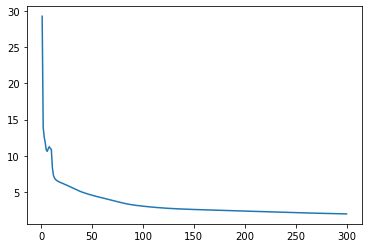

In [21]:
sns.lineplot(range(1, 301), residual2);